In [1]:
#!/usr/bin/env python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#load the modelfile components
startmod=open('../start.mod','r')
lines=startmod.readlines()
startmod.close()
headerlines = lines[:12]

startmoddata = pd.read_csv('../start.mod',skiprows=12,header=0,sep='\s+',names=['H','vp','vs','rho','qp','qs','etap','etas',\
                                                                             'frefp','frefs'])

#ebhmodeldata = pd.read_csv('../start.mod',skiprows=12,header=0,sep='\s+',\
#                          names=['H','vp','vs','rho','qp','qs','etap','etas',\'frefp','frefs'])

startmoddata['depth'] = np.cumsum(startmoddata.H)

#Get just the part of the model where the layer depths are == 10
H10 = startmoddata[startmoddata.H == 10]
HLT10 = startmoddata[startmoddata.H < 10.0]


In [4]:
from scipy.interpolate import interp1d

In [5]:
inc = 5 #maximum depth increment to use in the model
deps = np.arange(min(H10.depth.values),max(H10.depth.values),inc)

#Create interpolation functions for vp and vs
finterpP = interp1d(H10.depth.values,H10.vp.values)
finterpS = interp1d(H10.depth.values,H10.vs.values)
finterpRHO = interp1d(H10.depth.values,H10.rho.values)

#Interpolate to the finer depth grid
newvp = finterpP(deps)
newvs = finterpS(deps)
newrho = finterpRHO(deps)

#Create vector of new increment values
newH = inc*np.ones(len(deps))
#Create new vectors for all the other values
newqp = H10.qp.values[0]*np.ones(len(deps))
newqs = H10.qs.values[0]*np.ones(len(deps))
newqs = H10.qs.values[0]*np.ones(len(deps))
newetap = H10.etap.values[0]*np.ones(len(deps))
newetas = H10.etas.values[0]*np.ones(len(deps))
newfrefp = H10.frefp.values[0]*np.ones(len(deps))
newfrefs = H10.frefs.values[0]*np.ones(len(deps))

newH10 = pd.DataFrame({'H': newH, 'vp': newvp, 'vs': newvs, 'rho': newrho, 'qp': newqp, 'qs': newqs, 'etap': newetap,\
                       'etas': newetas, 'frefp': newfrefp, 'frefs': newfrefs, 'depth': deps})



In [6]:
#concatinate the dataframes
frames = [HLT10, newH10]
newdf = pd.concat(frames)
newdf = newdf[newdf.depth <= 350] #cut off depths below 250km 

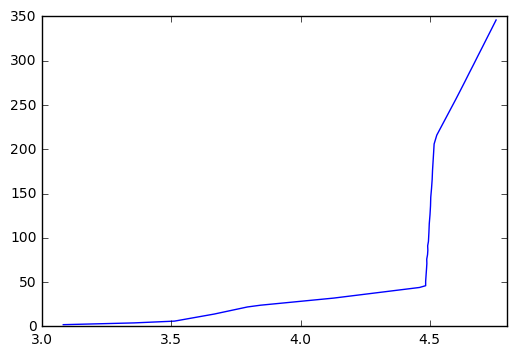

In [7]:
plt.plot(newdf.vs,newdf.depth)

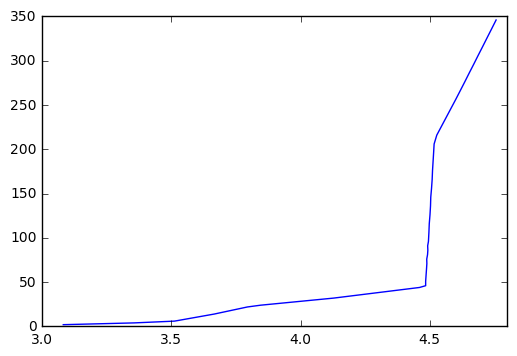

In [8]:
startmoddata = startmoddata[startmoddata.depth <= 350] #cut off depths below 500km
plt.plot(startmoddata.vs,startmoddata.depth)

In [9]:
#now write the final model file
outfilename = 'start_ebh_ALL.mod'
outfile = open(outfilename,'w')
for line in headerlines:
    outfile.write(line)
    
for i, row in newdf.iterrows():
    
    outfile.write('  %.4f  %.4f  %.4f  %.4f  %.0f  %.0f  %.2f  %.2f  %.2f  %.2f\n'\
                     %(row.H,row.vp,row.vs,row.rho,row.qp,row.qs,row.etap,row.etas,\
                       row.frefp,row.frefs))
                
outfile.close()